In [1]:
import pickle
from wavelength_aggregation import *
import matplotlib.pyplot as plt

In [2]:
# Load the data
with open('../data/snr_data.pkl', 'rb') as f:
    snr_data = pickle.load(f)

with open('../data/snr_thresholds.pkl', 'rb') as f:
    snr_thresholds = pickle.load(f)

In [3]:
# Generate the results used for Figures 6a and 6b

NUM_WAVELENGTHS = 50
MAX_CAPACITY = 5000
MIN_CAPACITY = 3000

LINK_TO_ANALYZE = 21

availability_targets = [0.990, 0.991, 0.992, 0.993, 0.994]

capacity_dist = gen_prob_dist(snr_data[LINK_TO_ANALYZE], snr_thresholds)

results = []

for target in availability_targets:
    counts = bin_packing_algorithm(capacity_dist, NUM_WAVELENGTHS, MAX_CAPACITY, MIN_CAPACITY, target)
    results.append(counts)

print(results)

[{250: 20, 200: 0, 150: 0}, {250: 20, 200: 0, 150: 0}, {250: 20, 200: 0, 150: 0}, {200: 15, 250: 8, 150: 0}, {150: 20, 250: 8, 200: 0}]


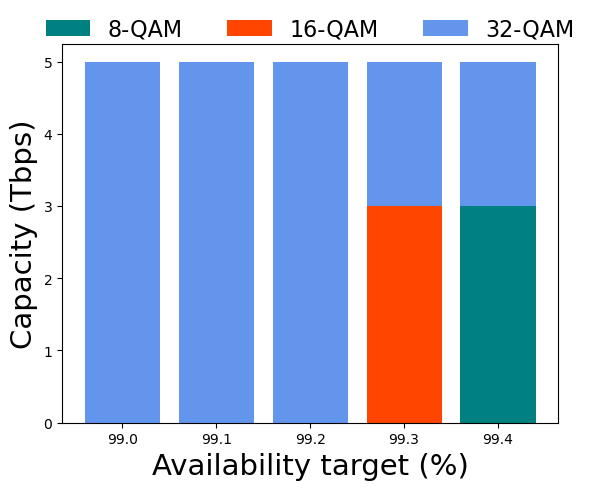

In [4]:
# Plot Figure 6a

data_rates = [150, 200, 250]

plot_values = {}
for data_rate in data_rates:
    plot_values[data_rate] = []

for result in results:
    for data_rate in result:
        plot_values[int(data_rate)].append(result[data_rate] * int(data_rate) / 1000)

fig, ax = plt.subplots()
plt.rcParams.update({'font.size': 16})

labels = {
    150: '8-QAM',
    200: '16-QAM',
    250: '32-QAM'
}

colors = {
    250: 'cornflowerblue',
    200: 'orangered',
    150: 'teal'
}

prev_seen = [0] * len(results)
plot_values = dict(sorted(plot_values.items()))
for capacity in plot_values:
    bar_i = ax.bar([str(target * 100) for target in availability_targets], plot_values[capacity], bottom=prev_seen, label=labels[capacity], color=colors[capacity])
    for i in range(len(prev_seen)):
        prev_seen[i] += plot_values[capacity][i]

# Adding labels and title
ax.set_xlabel('Availability target (%)', fontsize=21)
ax.set_ylabel('Capacity (Tbps)', fontsize=21)
ax.legend(loc='upper center', bbox_to_anchor=(0.5,1.12), frameon=False, ncols=3)
plt.subplots_adjust(top=0.9)
plt.show()

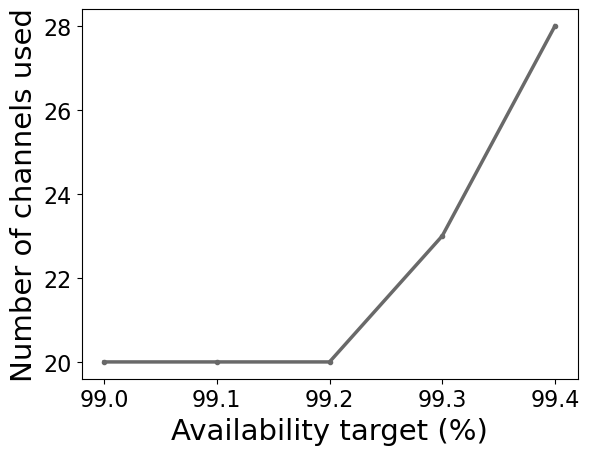

In [5]:
# Plot Figure 6b

plt.plot([100 * target for target in availability_targets], [int(sum(result.values())) for result in results], marker='.', color='dimgray', lw=2.5)
plt.xlabel('Availability target (%)', fontsize=21)
plt.ylabel('Number of channels used', fontsize=21)
plt.xticks([x * 100 for x in availability_targets])
plt.show()

In [6]:
# Run evaluation for channel usage suboptimality after incoprorating wavelength-dependent losses

AVAILABILITY_TARGET = 0.999
max_capacities = [1000, 5000, 10000, 15000]
min_capacity_ratios = [0.25, 0.5, 0.75]
NUM_WAVELENGTHS = 80

exp_results = {min_capacity_ratio: {max_capacity: [] for max_capacity in max_capacities} for min_capacity_ratio in min_capacity_ratios}
for min_capacity_ratio in min_capacity_ratios:
    for link, snrs in snr_data.items():
        for max_capacity in max_capacities:
            prob_dist1 = gen_prob_dist([x + 2 if x > 0.1 else x for x in snrs], snr_thresholds)
            counts1 = bin_packing_algorithm(prob_dist1, NUM_WAVELENGTHS, max_capacity, max_capacity * min_capacity_ratio, AVAILABILITY_TARGET)
            prob_dist2 = gen_prob_dist(snrs, snr_thresholds)
            counts2 = bin_packing_algorithm(prob_dist2, NUM_WAVELENGTHS, max_capacity, max_capacity * min_capacity_ratio, AVAILABILITY_TARGET)
            if counts1 is not None and counts2 is not None:
                exp_results[min_capacity_ratio][max_capacity].append(sum([v for v in counts2.values()]) - sum([v for v in counts1.values()]))

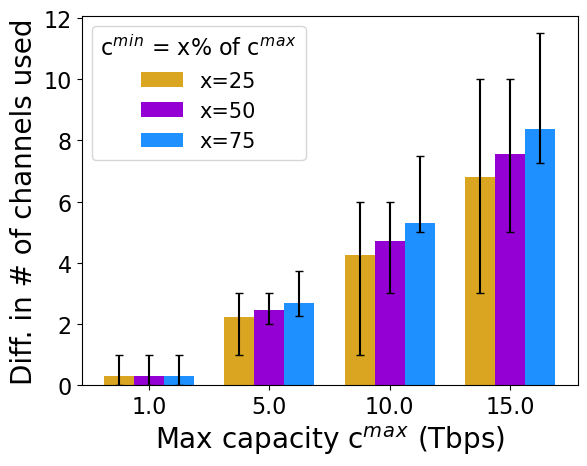

In [7]:
# Plot Figure 6c

fig, ax = plt.subplots()
plt.rcParams.update({'font.size': 16})
colors = {0.25: 'goldenrod', 0.5: 'darkviolet', 0.75: 'dodgerblue'}
x = np.arange(len(max_capacities))

i = 0
for min_capacity_ratio, results in exp_results.items():
    means = [np.mean(result) for result in results.values()]
    p25 = [mean - np.percentile(result, 25) for mean, result in zip(means, results.values())]
    p75 = [np.percentile(result, 75) - mean for mean, result in zip(means, results.values())]
    ax.bar(x + (0.25 * i), means, 0.25, yerr=[p25, p75], capsize=3, color=colors[min_capacity_ratio], label=f'x={int(min_capacity_ratio * 100)}')
    i += 1

# Add labels and title
ax.set_xlabel('Max capacity c$^m$$^a$$^x$ (Tbps)', fontsize=20)
ax.set_ylabel('Diff. in # of channels used', fontsize=20)
ax.legend(title=f'c$^m$$^i$$^n$ = x% of c$^m$$^a$$^x$', fontsize=15)
ax.set_xticks(x + 0.25)
ax.set_xticklabels([x / 1000 for x in max_capacities])

plt.show()